In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "07_training/07b_efficient_preproc.ipynb"
_nb_title = "GPU utilization"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=GPU+utilization&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F07_training%2F07b_efficient_preproc.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/07_training/07b_efficient_preproc.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/07_training/07b_efficient_preproc.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/07_training/07b_efficient_preproc.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 効率的な前処理

このノートブックでは、前処理グラフを最適化し、効率的に前処理をする方法を確認します。

## 実行環境
このノートブックではアクセレレータは必要ありませんが、アクセレレータがあればバッチ処理の箇所だけ自動的に利用されます。

以下に記載されている数値は`us-central`に配置したVertex AI Workbench n1-standard-4インスタンスにNVIDIA T4 GPUをアタッチした環境で計測されています。

**注: Colabを利用した場合、実行環境のロケーションを選択することができません。そのため、データが置かれているロケーション (`us-central1`)と遠くなり、ネットワークのオーバーヘッドの方が大きくなる可能性があります。正確な比較を行いたい場合、Vertex AI Workbenchでロケーションを`us-central1`に指定してインスタンスを作成し、実行するようにしてください。**

Vertex AI WorkbenchやColabでGPUやTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

## データの取り込み

In [2]:
%%writefile input.txt
gs://practical-ml-vision-book/images/california_fire1.jpg
gs://practical-ml-vision-book/images/california_fire2.jpg

Overwriting input.txt


2022-07-16 19:56:16.440400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-16 19:56:16.440448: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-16 19:56:18.234172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-16 19:56:18.234230: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-16 19:56:18.234256: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-direct): /proc/driver/nvidia/version does not exist
2022-07-16 19:56:18.234582: I tensorflow/core/platform/cpu_feature

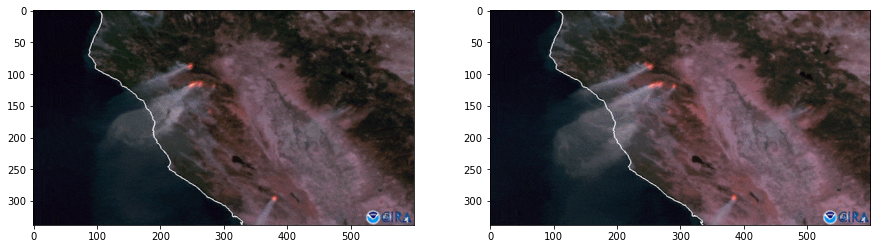

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

def read_jpeg(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [338, 600, 3])
    return img

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    
    ax[idx].imshow( img.numpy() );

## map関数の追加  

画像の変換のためにカスタム関数を適用します。

(338, 600)


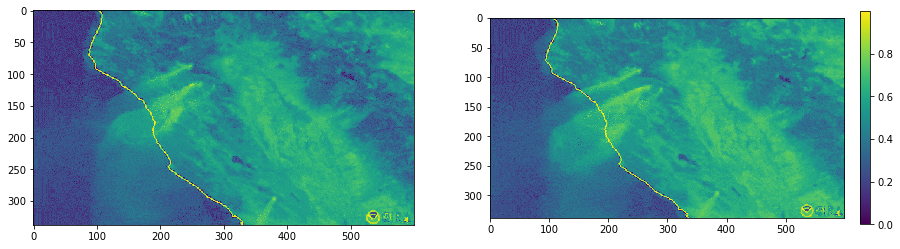

In [4]:
def to_grayscale(img):
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    print(gray.shape)
    return gray

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    im = ax[idx].imshow( img.numpy() , interpolation='none');
    if idx == 1:
        f.colorbar(im, fraction=0.028, pad=0.04)

### 1. ピクセル毎のイテレーション  

この方法はおすすめしません。

In [5]:
# This function is not accelerated. At all.
def to_grayscale(img):
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    return result

In [6]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg)

overall = tf.constant([0.], dtype=tf.float32)
count = 0
for img in ds:
    # Notice that we have to call .numpy() to move the data outside TF Graph
    gray = to_grayscale(img.numpy())
    # This moves the data back into the graph
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 33.2 s, sys: 416 ms, total: 33.6 s
Wall time: 32.7 s


### 2. Pyfunc  

Pythonでのみ使用可能な関数(time/jsonなど)を繰り返しまたは呼び出す必要があり、それでもmap()を使用する必要がある場合は、py_funcを使用することで実行できます。

しかし、データはグラフの外で処理され、実行後に再度グラフに戻されます。したがって、効率の面での利益はありません。

In [7]:
def to_grayscale_numpy(img):
    # the numpy happens here
    img = img.numpy()
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    # the convert back happens here
    return tf.convert_to_tensor(result)

def to_grayscale(img):
    return tf.py_function(to_grayscale_numpy, [img], tf.float32)

In [8]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.], dtype=tf.float32)
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 32.9 s, sys: 455 ms, total: 33.3 s
Wall time: 32.4 s


### 3. TensorFlowのスライシングとtf.whereの利用

これにより、ピクセルごとにイテレーションするよりも50倍ほど高速になります。

In [9]:
# All in GPU
def to_grayscale(img):
    # TensorFlow slicing functionality
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    # All these are actually tf.mul(), tf.add(), etc.
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    # Use tf.cond and tf.where for if-then statements
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [10]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.])
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331072], shape=(1,), dtype=float32)
CPU times: user 973 ms, sys: 432 ms, total: 1.41 s
Wall time: 417 ms


### 4. 行列計算の使用

これにより、処理がさらに効率化されます

In [11]:
def to_grayscale(img):
    wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
    c_linear = tf.matmul(img, wt) # (ht,wd,3) x (3x1) -> (ht, wd)
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [12]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.])
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331072], shape=(1,), dtype=float32)
CPU times: user 936 ms, sys: 437 ms, total: 1.37 s
Wall time: 372 ms


### 5. バッチ処理  
画像のバッチに対して実行できるように、処理を完全にベクトル化します。

Kerasの層として定義しているので、アクセレレータが利用可能な場合より高速に動作します。<br>
その場合、一回目の実行時にはグラフをメモリに乗せる処理のオーバーヘッドがありますので、2度目の実行時の方が高速になります。

In [13]:
class Grayscale(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Grayscale, self).__init__(**kwargs)
    
    def call(self, img):
        wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
        c_linear = tf.matmul(img, wt) # (N, ht,wd,3) x (3x1) -> (N, ht, wd)
        gray = tf.where(c_linear > 0.0031308,
                        1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                        12.92*c_linear)
        return gray # (N, ht, wd)

model = tf.keras.Sequential([
    Grayscale(trainable=False,input_shape=(338, 600, 3)),
    tf.keras.layers.Lambda(lambda gray: tf.reduce_mean(gray, axis=[1, 2])) # note axis change
])

In [14]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).batch(5)
overall = tf.constant([0.])
count = 0
for batch in ds:
    bm = model(batch)
    overall += tf.reduce_sum(bm)
    count += len(bm)
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 909 ms, sys: 551 ms, total: 1.46 s
Wall time: 327 ms


## 結果

|方法         |CPU時間 |実測時間 |
|:--          |:--     |:--      |
|イテレーション     |33.2 s  |32.7 s   |
|pyfunc       |32.9 s  |32.4 s   |
|スライス処理 |0.97 s  |0.42 s   |
|行列の乗算   |0.94 s  |0.37 s   |
|バッチ処理   |0.91 s  |0.32 s   |

注: 実行するアクセレレータやTensorFlowバージョンによって異なります。


## Signature 

以下では、Signatureの挙動を確認します。

In [15]:
from inspect import signature

def myfunc(a, b):
    return (a + b)

print(myfunc(3,5))
print(myfunc('foo', 'bar'))
print(signature(myfunc).parameters)
print(signature(myfunc).return_annotation)

8
foobar
OrderedDict([('a', <Parameter "a">), ('b', <Parameter "b">)])
<class 'inspect._empty'>


In [16]:
from inspect import signature

def myfunc(a: int, b: float) -> float:
    return (a + b)

print(myfunc(3,5))
print(myfunc('foo', 'bar')) # runtime doesn't check
print(signature(myfunc).parameters)
print(signature(myfunc).return_annotation)

8
foobar
OrderedDict([('a', <Parameter "a: int">), ('b', <Parameter "b: float">)])
<class 'float'>


In [17]:
from inspect import signature
import tensorflow as tf

@tf.function(input_signature=[
    tf.TensorSpec([3,5], name='a'),
    tf.TensorSpec([5,8], name='b')
])
def myfunc(a, b):
    return (tf.matmul(a,b))

print(myfunc.get_concrete_function())
print("*" * 10)
print(myfunc.get_concrete_function()(tf.ones((3,5)), tf.ones((5,8))))

ConcreteFunction myfunc(a, b)
  Args:
    a: float32 Tensor, shape=(3, 5)
    b: float32 Tensor, shape=(5, 8)
  Returns:
    float32 Tensor, shape=(3, 8)
**********
tf.Tensor(
[[5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5.]
 [5. 5. 5. 5. 5. 5. 5. 5.]], shape=(3, 8), dtype=float32)


## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.